# Overvieview of the different samplers of the package

In [1]:
import numpy as np

from black_it.search_space import SearchSpace
from black_it.samplers.random_uniform import RandomUniformSampler
from black_it.samplers.halton import HaltonSampler
from black_it.samplers.r_sequence import RSequenceSampler
from black_it.samplers.random_forest import RandomForestSampler
from black_it.samplers.gaussian_process import GaussianProcessSampler
from black_it.samplers.best_batch import BestBatchSampler
from black_it.samplers.particle_swarm import ParticleSwarmSampler

import matplotlib.pyplot as plt

In this notebook we will illustrate the inner working of the samplers of the package. For ease of visualization we will focus exclusively on a simple two-dimensional parameter space. 


In [2]:
# define a 2-dimensional grid of possible parameter values between 0 and 1.

param_grid = SearchSpace(
    parameters_bounds=np.array([[0, 1], [0, 1]]).T,
    parameters_precision=[0.01, 0.01],
    verbose=False,
)

## Random Uniform (Trivial) Sampler

The simplest sampler is a sampler that proposes completely random parameters.

In [3]:
sampler = RandomUniformSampler(batch_size=50, random_state=0)
new_params = sampler.sample(param_grid, np.zeros((0, 2)), np.zeros((0, 2)))

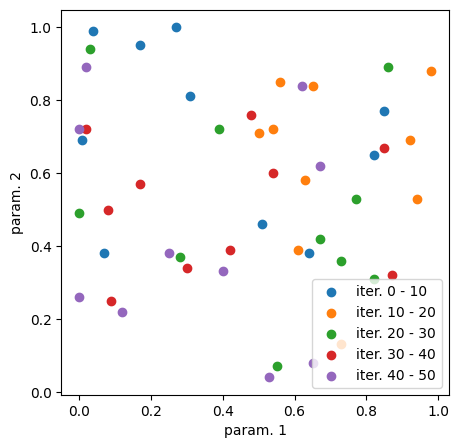

In [4]:
plt.figure(figsize=(5, 5))
for i in range(5):
    plt.scatter(
        new_params[i * 10 : (i + 1) * 10, 0],
        new_params[i * 10 : (i + 1) * 10, 1],
        label="iter. " + str(i * 10) + " - " + str((i + 1) * 10),
    )

plt.xlabel("param. 1")
plt.ylabel("param. 2")
plt.legend()

## Low discrepancy samplers

As you can see from the graph above, random uniform sampling is not very effective at covering the parameter space uniformly (in spite of the name). To address this problem one can use a series of samplers designed to provide _low discrepancy_. These are discussed in the folling.

### Halton Sampler

In [5]:
sampler = HaltonSampler(batch_size=50, random_state=0)
new_params = sampler.sample(param_grid, np.zeros((0, 2)), np.zeros((0, 2)))

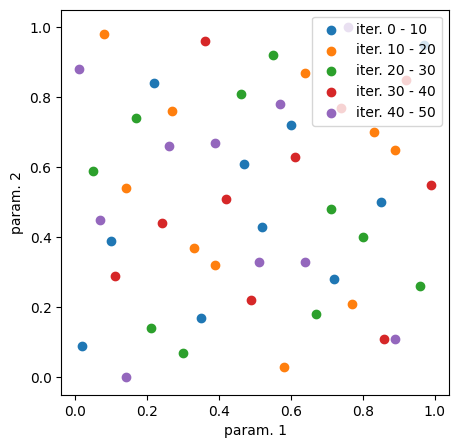

In [6]:
plt.figure(figsize=(5, 5))
for i in range(5):
    plt.scatter(
        new_params[i * 10 : (i + 1) * 10, 0],
        new_params[i * 10 : (i + 1) * 10, 1],
        label="iter. " + str(i * 10) + " - " + str((i + 1) * 10),
    )

plt.xlabel("param. 1")
plt.ylabel("param. 2")
plt.legend()

### R-Sequence Sampler

In [7]:
sampler = RSequenceSampler(batch_size=50, random_state=0)
new_params = sampler.sample(param_grid, np.zeros((0, 2)), np.zeros((0, 2)))

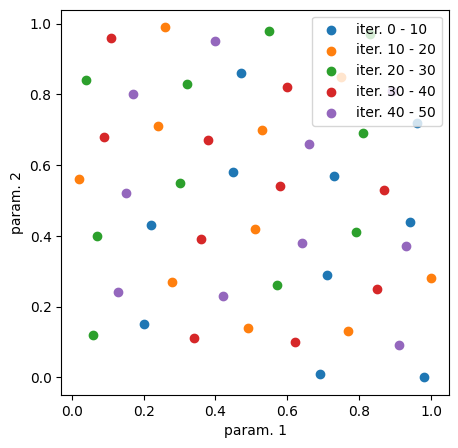

In [8]:
plt.figure(figsize=(5, 5))
for i in range(5):
    plt.scatter(
        new_params[i * 10 : (i + 1) * 10, 0],
        new_params[i * 10 : (i + 1) * 10, 1],
        label="iter. " + str(i * 10) + " - " + str((i + 1) * 10),
    )

plt.xlabel("param. 1")
plt.ylabel("param. 2")
plt.legend()

## Adaptive samplers

Certain samplers exploit the information collected during previous calibration steps to adaptively propose optimal sampling regions to explore. These adaptive samplers are discussed in the following.

In [9]:
# In the folliwing we will assume that the value of the loss function
# is known on a grid of points in parameter space

def target_loss(x, y):
    return 5 * (x**2 + y**2)
    
xs = np.linspace(0, 1, 6) 
ys = np.linspace(0, 1, 6) 
xys = []
losses = []

for x in xs:
    for y in ys:
        # a small noise is needed to avoid 
        # unrealistically simmetric sampling
        x = x + np.random.normal(0, 1e-2)
        y = y + np.random.normal(0, 1e-2)
        xys.append([x, y])
        losses.append(target_loss(x, y))

xys = np.array(xys)
losses = np.array(losses)

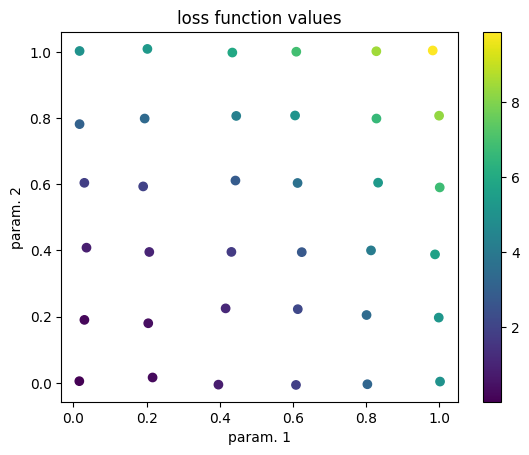

In [10]:
plt.title("loss function values")
plt.scatter(xys[:, 0], xys[:, 1], c=losses)
plt.xlabel("param. 1")
plt.ylabel("param. 2")
plt.colorbar()

### Random Forest Sampler

In [11]:
sampler = RandomForestSampler(batch_size=16, random_state=0)
new_params = sampler.sample(param_grid, xys, losses)

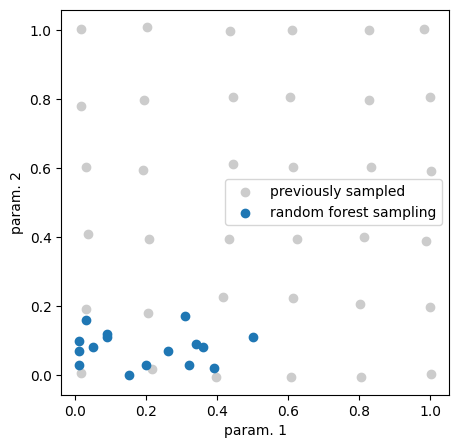

In [12]:
plt.figure(figsize=(5, 5))

plt.scatter(xys[:, 0], xys[:, 1], c="0.8", label="previously sampled")

plt.scatter(new_params[:, 0], new_params[:, 1], label="random forest sampling")

plt.xlabel("param. 1")
plt.ylabel("param. 2")
plt.legend()

### Gaussian Process Sampler ("Bayesian Optimisation")

In [13]:
sampler = GaussianProcessSampler(batch_size=8, random_state=0, acquisition="mean")
new_params_mean_acquisition = sampler.sample(param_grid, xys, losses)


 /Users/aldoglielmo/miniconda3/envs/py39_2/lib/python3.9/site-packages/GPy/kern/src/stationary.py:581: RuntimeWarning:overflow encountered in square
 /Users/aldoglielmo/miniconda3/envs/py39_2/lib/python3.9/site-packages/GPy/kern/src/stationary.py:581: RuntimeWarning:invalid value encountered in multiply
 /Users/aldoglielmo/miniconda3/envs/py39_2/lib/python3.9/site-packages/GPy/kern/src/stationary.py:584: RuntimeWarning:overflow encountered in square
 /Users/aldoglielmo/miniconda3/envs/py39_2/lib/python3.9/site-packages/GPy/kern/src/stationary.py:584: RuntimeWarning:invalid value encountered in multiply
 /Users/aldoglielmo/miniconda3/envs/py39_2/lib/python3.9/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /Users/aldoglielmo/miniconda3/envs/py39_2/lib/python3.9/site-packages/GPy/kern/src/stationary.py:581: RuntimeWarning:overflow encountered in multiply
 /Users/aldoglielmo/miniconda3/envs/py39_2/lib/python3.9/site-packages/GPy/kern/src/statio

In [14]:
sampler = GaussianProcessSampler(
    batch_size=8, random_state=0, acquisition="expected_improvement"
)
new_params_EI_acquisition = sampler.sample(param_grid, xys, losses)

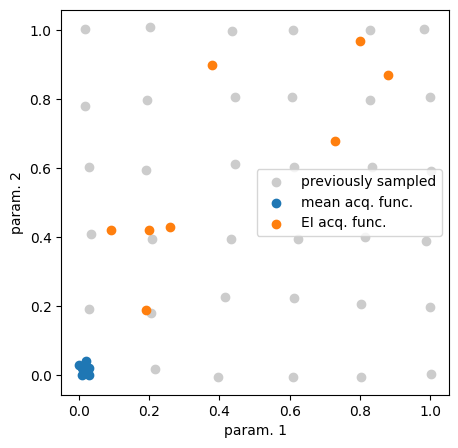

In [15]:
# note that the expected_improvement acquisition function automatically
# tries to strike a balance between "exploration" and "exploitation"

plt.figure(figsize=(5, 5))

plt.scatter(xys[:, 0], xys[:, 1], c="0.8", label="previously sampled")

plt.scatter(
    new_params_mean_acquisition[:, 0],
    new_params_mean_acquisition[:, 1],
    label="mean acq. func.",
)
plt.scatter(
    new_params_EI_acquisition[:, 0],
    new_params_EI_acquisition[:, 1],
    label="EI acq. func.",
)

plt.xlabel("param. 1")
plt.ylabel("param. 2")
plt.legend()

### Best Batch ("Genetic") Sampler

In [16]:
sampler = BestBatchSampler(batch_size=16, random_state=0)
new_params = sampler.sample(param_grid, xys, losses)

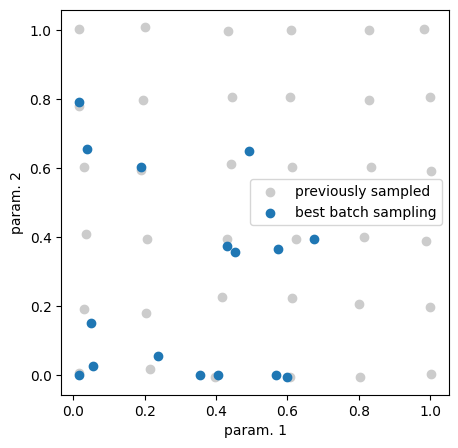

In [17]:
plt.figure(figsize=(5, 5))
plt.scatter(xys[:, 0], xys[:, 1], c="0.8", label="previously sampled")


plt.scatter(new_params[:, 0], new_params[:, 1], label="best batch sampling")

plt.xlabel("param. 1")
plt.ylabel("param. 2")
plt.legend()

### Particle Swarm Sampler

In [31]:
from collections import defaultdict

# short PS dynamics with 4 particles for 10 timesteps
batch_size = 4
nb_iterations = 10
sampler = ParticleSwarmSampler(batch_size=batch_size, 
                               random_state=0, 
                               global_minimum_across_samplers=False)

# here we start with no evaluated losses
points_ = np.zeros((0, 2))
losses_ = np.array([])


particle_trajectory = defaultdict(lambda: [])

for i in range(nb_iterations):
    current_positions = sampler.sample(param_grid, points_, losses_)
    current_losses = []
    for particle_id, point in enumerate(current_positions):
        outputs = []
        loss = target_loss(point[0], point[1])
        current_losses.append(loss)
        particle_trajectory[particle_id].append(point)
        
    points_ = np.concatenate([points_, current_positions])
    losses_ = np.concatenate([losses_, current_losses])


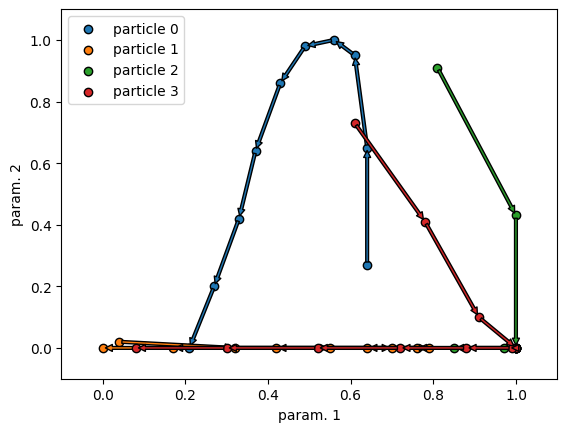

In [32]:
import matplotlib.patches as mpatches

fig = plt.figure()
axes = plt.axes()

def plot_trajectory(trajectory, axes, marker = "o", label=None, color=None):
    trajectory = np.array(trajectory)
    path_obj = axes.scatter(
        trajectory[:, 0],
        trajectory[:, 1],
        label=label,
        edgecolors='black',
        marker=marker,
        color=color
    )
    color = path_obj.get_facecolor()[0] if color is None else color
    for step_id in range(0, len(trajectory) - 1):
        p1, p2 = trajectory[step_id], trajectory[step_id+1]
        arrow = mpatches.FancyArrowPatch(p1, p2, facecolor=color, mutation_scale=10, edgecolor='black')
        axes.add_patch(arrow)

# plot trajectories
for particle_id, trajectory_i in particle_trajectory.items():
    plot_trajectory(trajectory_i, axes, label=f"particle {particle_id}")


plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xlabel("param. 1")
plt.ylabel("param. 2")
plt.legend()